# Procesamiento de Imágenes - Trabajo Práctico N°3
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from random import randint
import cv2

# Ejercicio 1

In [2]:
original_image = np.array(Image.open('assets/Fig0448.tif'))

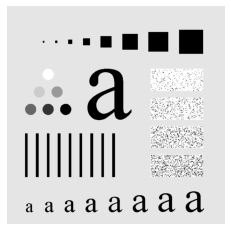

In [3]:
plt.axis('off')
plt.imshow(original_image, cmap='gray')
plt.show()

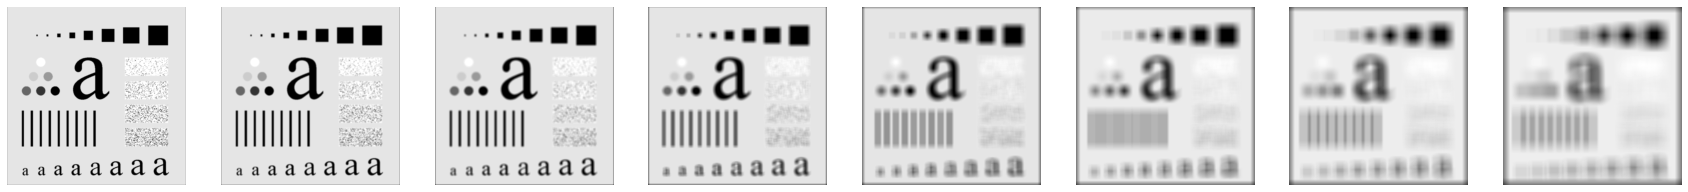

In [4]:
n = [3,5,9,15,25,35,45,55]
fig, axs = plt.subplots(1, len(n), figsize=(30,30))
for i, n_ in enumerate(n):
    a = n_**-2
    kernel = np.array([[a]*n_]*n_)
    image = convolve2d(original_image, kernel, mode='same')
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')

# Ejercicio 2

In [5]:
img = np.array(Image.open('assets/galaxy2.tif'))
# Scale image to get 8 bits grayscale
info = np.iinfo(img.dtype) 
img = img.astype(np.float64) / info.max 
img = 255 * img
original_image = img.astype(np.uint8)

Filter the image with a 15x15 LowPass

In [6]:
n = 15
a = n**-2
kernel = np.array([[a]*n]*n)
filtered_image = convolve2d(original_image, kernel, mode='same')

Apply a threshold of 0.25 to the filtered image

In [7]:
th = 0.25
max_val = np.iinfo(original_image.dtype).max 
th_image = (filtered_image > th*max_val).astype(np.uint8)*max_val

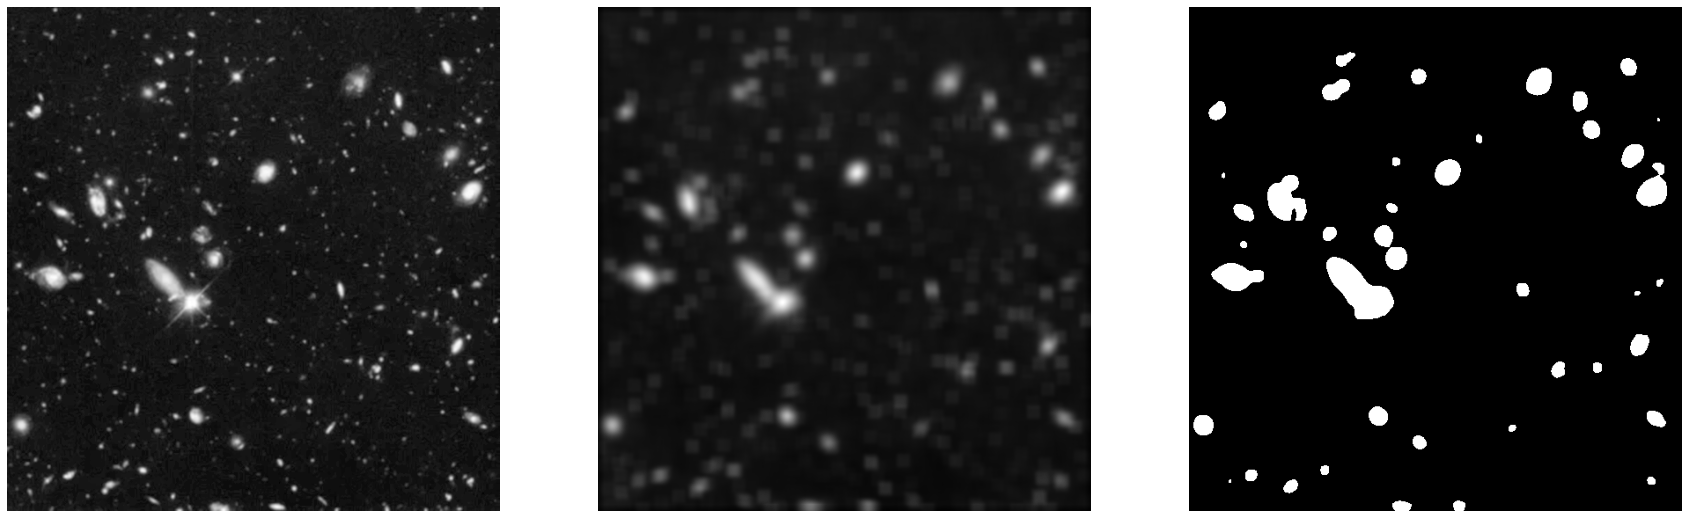

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(30,30))
axs[0].axis('off')
axs[0].imshow(original_image, cmap='gray')

axs[1].axis('off')
axs[1].imshow(filtered_image, cmap='gray')

axs[2].axis('off')
axs[2].imshow(th_image, cmap='gray')

# Ejercicio 3 - Filtro mediana

In [9]:
original_image = np.array(Image.open('assets/coins.bmp').convert('L'))

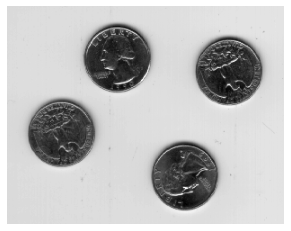

In [10]:
plt.axis('off')
plt.imshow(original_image, cmap='gray')
plt.show()

In [11]:
def add_salt_and_pepper(arr_, d):
    """
    This function returns the image with salt&pepper noise
    
    Parameters
    ----------
        'arr_':           array_like - image to add noise
        'd':              float (0.0,1.0) - approximate ratio of affected pixels
    Returns
    ----------
        'arr':            array_like - Resulting image
    """
    row, col = arr_.shape
    arr = arr_.copy()
    num = min(int(d*row*col), int(row*col))
    for _ in range(num):
        x, y = randint(0,row-1), randint(0,col-1)
        color = 255 if randint(0,100)/100 > 0.5 else 0
        arr[x][y] = color
    return arr

In [12]:
def median_filter(image):
    """
    This function returns the filtered image using a median filter
    
    Parameters
    ----------
        'image':          array_like - image to be filter
    Returns
    ----------
        'filtered_img':   array_like - Resulting image
    """
    row, col = image.shape
    filtered_img = np.zeros((row, col), dtype=float)
    # Padding to work with the images borders without problems
    padded_img = np.pad(image, 1, mode='edge')
    mask = np.array([[0,1,0],[1,0,1],[0,1,0]])
    for i in range(row):
        for j in range(col):
            neighborhood = ((padded_img[i:i+3,j:j+3] + 1e-1) * mask).flatten()
            filtered_img[i][j] = np.uint8(np.median(neighborhood[neighborhood > 0] - 1e-1))
    return filtered_img

Primero se le agrega ruido a la imagen en una proporción de 0,02.

In [13]:
image_salted = add_salt_and_pepper(original_image, 0.02)

Luego se filtra la imagen con ruido utilizando un filtra pasa-bajos proporcional de 3x3.

In [14]:
n, a = 3, n**-2
kernel = np.array([[a]*n]*n)
filtered_image = convolve2d(image_salted, kernel, mode='same')

Finalmente se aplica el filtro mediana sobre la imagen con ruido.

In [15]:
image_median = median_filter(image_salted)

A continuación se muestran los resultados obtenidos de las operaciones anteriormente mecionadas.

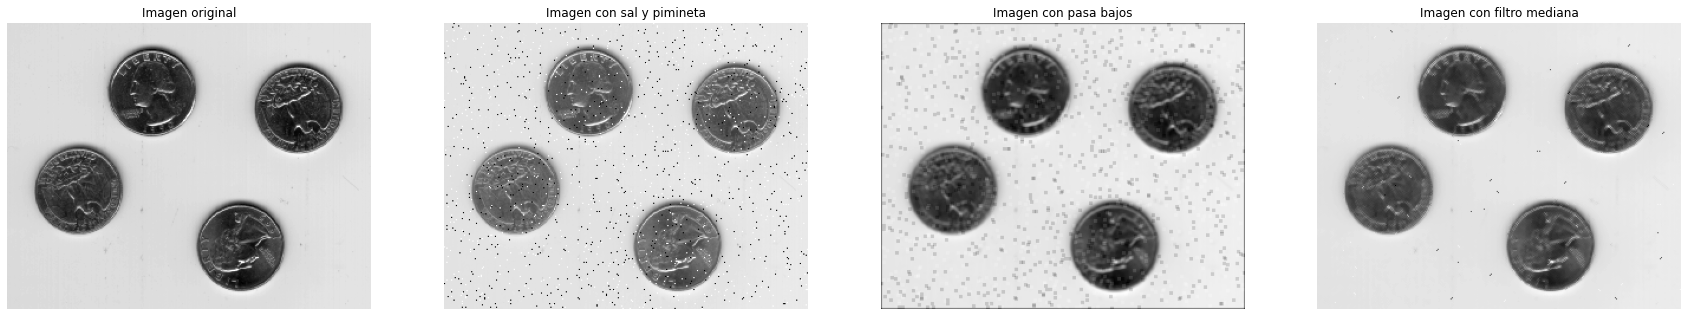

In [16]:
images = [original_image, image_salted, filtered_image, image_median]
titles = ['Imagen original', 'Imagen con sal y pimineta', 'Imagen con pasa bajos', 'Imagen con filtro mediana']
fig, axs = plt.subplots(1, len(images), figsize=(30,10))
for i in range(len(images)):
    axs[i].axis('off')
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(titles[i])


Es posible apreciar como al utilizar el filtro mediana se logra un mejor resultado, ya que el mismo permite que el fondo se recomponga de una forma más uniforme. Es decir, se logra que los pixeles con un nivel de gris diferente al de sus vecinos, se asemejen más a ellos, logrando asi eliminar los pixels blancos y negros provocados por el ruido. 

# Ejercicio 4 - Laplaciano

La idea detrás del laplaciano es recuperar el fondo sin perder con ello la información de los bordes.

Para eso primero leemos la imagen.

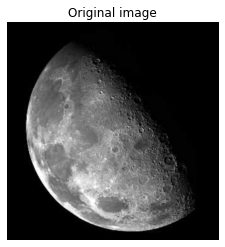

In [17]:
moon = cv2.imread('assets/moon.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(moon, cmap='gray', vmin=0, vmax=255)
plt.title("Original image")
plt.axis('off')
plt.show()

A continuación se muestra la funcion kernel_matrix que genera el kernel según el parámetro que se pasa como mode.

In [18]:
def kernel_matrix(mode, A = 1.0):
    """
    This function returns the kernel matrix according to the selected mode
    
    Parameters
    ----------
        'mode':  string_like - The working mode, it can be: diag_laplace to use diagonal kernel with laplace, 
                               diag_laplace_background to use diagonal kernel with laplace and background, 
                               hi_boost, to implement hi boost
        'A':           float - value to control the kernel in hi_boost mode
    Returns
    ----------
        'kernel': array_like - Resulting kernel
        '3':             int - kernal_dim 
    """
    if mode == 'diag_laplace':
        kernel = np.array(np.array([[1,1,1],[1, -8, 1],[1,1,1]]))
    elif mode == 'diag_laplace_background':
        kernel = np.array(np.array([[-1,-1,-1],[-1, 9, -1],[-1,-1,-1]]))
    elif mode == 'hi_boost':
        kernel = np.array(np.array([[-1,-1,-1],[-1, 8 + A, -1],[-1,-1,-1]]))
    else:
        print("Error, no acceptable case")
        
    return kernel, 3

La siguiente función se encarga de realizar el cálculo con el kernel para cada pixel de la imagen original.

In [19]:
def kernel_calculation(sub_img, x, y, mode, A):
    """
    This function returns the value after the kernel calculation per pixel
    
    Parameters
    ----------
        'sub_img':   array_like - image to be filter
        'x':                int - x coordinate of the pixel
        'y':                int - x coordinate of the pixel
        'mode':     string-like - The working mode, it can be: diag_laplace to use diagonal kernel with laplace, 
                                  diag_laplace_background to use diagonal kernel with laplace and background, 
                                  hi_boost, to implement hi boost
        'A':              float - value to control the kernel in hi_boost mode
    Returns
    ----------
        'val':            float - value for the current pixel after the kernel calculation
    """
    val = 0
    mask, mask_dim = kernel_matrix(mode,A=A)
    for i in range(mask_dim):
        for j in range(mask_dim):
            val += mask[i][j] * sub_img[i+x][j+y]
    return val

A continuación, se muestra la funcion desidered_filter, donde según el modo en el que funcione, se realiza el laplaciano o el hi boost que realizaremos en el siguiente ejercicio.

In [20]:
def desidered_filter(img, padding_mode="edge", mode="diag_laplace", A=0):
    """
    This function returns the filtered image
    
    Parameters
    ----------
        'img':            array_like - image to be filter
        'padding_mode':  string_like - image to be filter
        'mode':          string_like - The working mode, it can be: diag_laplace to use diagonal kernel with laplace, 
                                       diag_laplace_background to use diagonal kernel with laplace and background, 
                                       hi_boost, to implement hi boost
        'A':                   float - value to control the kernel in hi_boost mode
    Returns
    ----------
        'filtered_img': array_like - Resulting image
    """
    # variables initialization     
    [N, M] = img.shape
    filtered_img = np.zeros((N, M), dtype=float)
    # Padding to work with the images borders without problems
    padded_img = np.pad(img, 1, mode=padding_mode)
    for i in range(N):
        for j in range(M):
            filtered_img[i][j] = kernel_calculation(padded_img, i, j, mode, A)
    return filtered_img

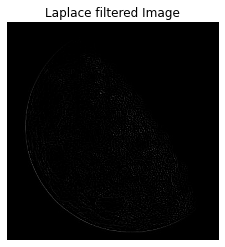

In [21]:
moon_laplaciano = desidered_filter(moon, mode='diag_laplace')
plt.imshow(moon_laplaciano, cmap='gray', vmin=0, vmax=255)
plt.title("Laplace filtered Image")
plt.axis('off')
plt.show()

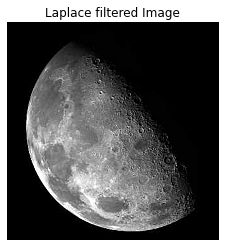

In [22]:
moon_laplaciano_con_fondo = desidered_filter(moon, mode='diag_laplace_background')
plt.imshow(moon_laplaciano_con_fondo, cmap='gray', vmin=0, vmax=255)
plt.title("Laplace filtered Image")
plt.axis('off')
plt.show()

De esta manera podemos ver a continuación las 2 imágenes para compararlas y observar el cambio que se genera en la imagen mediante el filtro laplaciano.

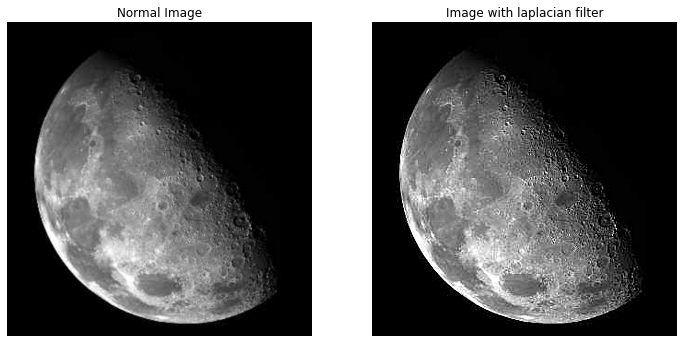

In [23]:
fig, axes = plt.subplots(1,2, figsize = (12,8))
axes[0].imshow(moon, cmap="gray")
axes[0].set_title("Normal Image")
axes[0].axis('off')
axes[1].imshow(moon_laplaciano_con_fondo, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Image with laplacian filter")
axes[1].axis('off')
plt.show()

# Ejercicio 5 - Hi Boost

Hi Boost funciona de manera similar a los filtros laplacianos, sólo que cambia el kernel fijo con el que se trabaja por un kernel modificable en función de un argumento A que se envía como parámetro.

Esto hace que podamos reutilizar las funciones del ejercicio anterior debido a que fueron realizadas para que funcionen de forma genérica únicamente modificando el modo de funcionamiento (argumento mode de la función desidered_filter).

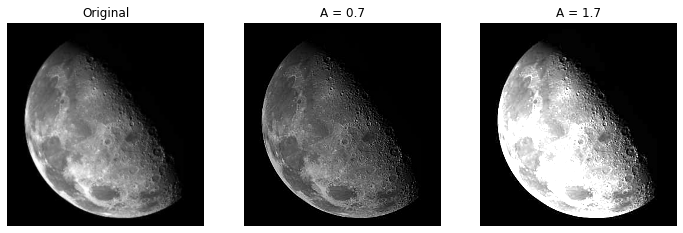

In [24]:
high_boost = cv2.imread('assets/moon.png', cv2.IMREAD_GRAYSCALE)
high_boost_1_7 = desidered_filter(high_boost, mode='hi_boost', A=1.7)
high_boost_0_7 = desidered_filter(high_boost, mode='hi_boost', A=0.7)

figure, axes = plt.subplots(ncols=3, figsize=(12, 8))
axes[0].imshow(high_boost, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original")
axes[0].axis('off')
axes[1].imshow(high_boost_0_7, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("A = 0.7")
axes[1].axis('off')
axes[2].imshow(high_boost_1_7, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("A = 1.7")
axes[2].axis('off')
plt.show()

Podemos ver en las imágenes generadas las diferencias que genera el parámetro A en la imagen resultante.

# Ejercicio 6 - Filtro homomórfico

En esta sección se trabajará con un filtro homomórfico para intentar apreciar los detalles de la imagen en las zonas oscuras.

A continuación se carga la imagen con la que se va a trabajar.

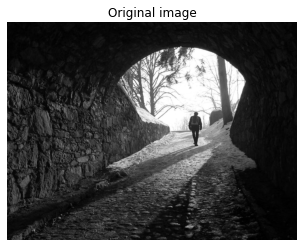

In [25]:
tunel = cv2.imread('assets/tun.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(tunel, cmap='gray', vmin=0, vmax=255)
plt.title("Original image")
plt.axis('off')
plt.show()

En la siguiente celda se puede ver la función homomorphic que implementa el filtro en cuestión. Para esto se hace uso de una funcion H que luego se multiplica en el dominio de la frecuencia.

Esta función H constituye el filtro homomórfico en cuestión, y presenta parámetros que son regulables en función de los resultados obtenidos en la imagen a la salida del filtro.

In [26]:
def homomorphic(img):
    """
    This function returns the filtered image
    
    Parameters
    ----------
        'img':            array_like - image to be filter
    Returns
    ----------
        'filtered_img':   array_like - Resulting image
    """
    # Constants
    [N, M] = img.shape
    gamma_h = 1
    gamma_l = 1.25
    img = np.array(img, dtype="float")
    x, y = np.meshgrid(np.linspace(-1, 1, M), np.linspace(-1, 1, N))
    d = np.sqrt((x * x) + (y * y))
    cut_off_frec = 5
    c = 0.25
    re = (1 - np.exp(-1*c*((d / cut_off_frec)**2)))
    H = (gamma_h - gamma_l) * re + gamma_l
    
    
    img[::] += 1 # offset to avoid -inf problem after log function.
    img_ln_h = np.fft.fftshift(np.fft.fft2(np.log(img)))
    for i in range(img_ln_h.shape[0]):
        for j in range(img_ln_h.shape[1]):
            img_ln_h[i][j] *= H[i][j]
    filtered_img = np.exp(np.real(np.fft.ifft2(np.fft.ifftshift(img_ln_h))))
    return filtered_img

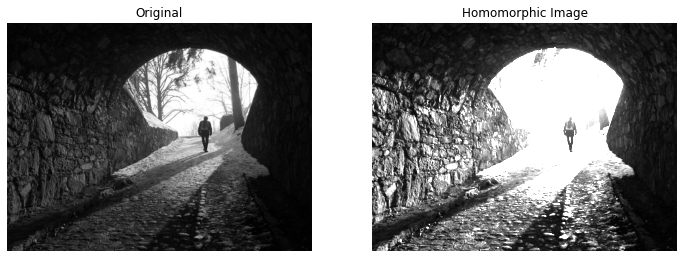

In [27]:
figure, axes = plt.subplots(ncols=2, figsize=(12, 12))
axes[0].imshow(tunel, cmap="gray", vmin=0, vmax=255)
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(homomorphic(tunel), cmap="gray", vmin=0, vmax=255)
axes[1].set_title('Homomorphic Image')
axes[1].axis('off')
plt.show()

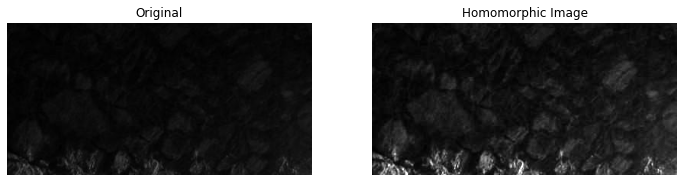

In [28]:
figure, axes = plt.subplots(ncols=2, figsize=(12, 12))
axes[0].imshow(tunel[0:200,0:400], cmap="gray", vmin=0, vmax=255)
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(homomorphic(tunel)[0:200,0:400], cmap="gray", vmin=0, vmax=255)
axes[1].set_title('Homomorphic Image')
axes[1].axis('off')
plt.show()

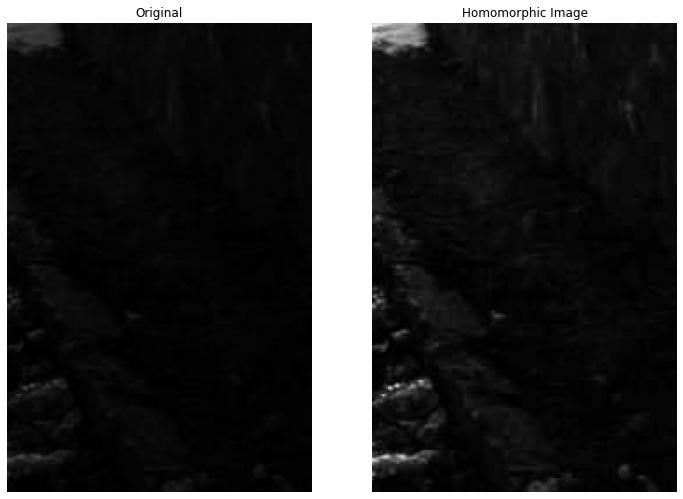

In [29]:
figure, axes = plt.subplots(ncols=2, figsize=(12, 12))
axes[0].imshow(tunel[500:,850:], cmap="gray", vmin=0, vmax=255)
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(homomorphic(tunel)[500:,850:], cmap="gray", vmin=0, vmax=255)
axes[1].set_title('Homomorphic Image')
axes[1].axis('off')
plt.show()

## Conclusiones del filtro Homomórfico

Podemos ver que luego del filtro la imagen mejora notablemente en las zonas oscuras, donde se pueden ver mejor los detalles que en la imagen original no se podían apreciar correctamente. Todo esto a costa de perder algo de definición en la imágenes con mucha iluminación debido a que se genera saturación en dichas zonas.

# Dato curioso

Hace algunos días fue noticia en la farándula argentina, una foto posteada por Laura Fernández (conocida en el medio como Laurita Fernández) en su cuenta de Instagram. La noticia se generó debido a que uno de los seguidores de la cuenta aseveraba que en el reflejo del horno se podía apreciar que era su expareja (Nicolás Cabré) la que sacó la fotografía, mostrando la posibilidad de un reencuentro entre los famosos.

Por lo tanto nos propusimos comprobar estas aseveraciones haciendo uso de nuestro filtro homomórfico que justamente logra lo que queremos hacer en este caso: amplificar los detalles en las zonas oscuras de la imagen.

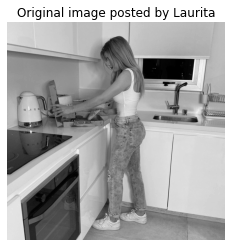

In [30]:
laurita = cv2.imread('assets/laurita_f.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(laurita, cmap='gray', vmin=0, vmax=255)
plt.title("Original image posted by Laurita")
plt.axis('off')
plt.show()

A continuación definimos nuevamente nuestra función homomorphic debido a que necesitamos modificar sus parámetros para que se adapten a nuestra nueva imagen.

In [31]:
def homomorphic(img):
    """
    This function returns the filtered image
    
    Parameters
    ----------
        'img':            array_like - image to be filter
    Returns
    ----------
        'filtered_img':   array_like - Resulting image
    """
    # Constants
    [N, M] = img.shape
    gamma_h = 1
    gamma_l = 1.8
    img = np.array(img, dtype="float")
    x, y = np.meshgrid(np.linspace(-1, 1, M), np.linspace(-1, 1, N))
    d = np.sqrt((x * x) + (y * y))
    cut_off_frec = 5
    c = 1.3
    re = (1 - np.exp(-1*c*((d / cut_off_frec)**2)))
    H = (gamma_h - gamma_l) * re + gamma_l
    
    img[::] += 3 # offset to avoid -inf problem after log function.
    img_ln_h = np.fft.fftshift(np.fft.fft2(np.log(img)))
    for i in range(img_ln_h.shape[0]):
        for j in range(img_ln_h.shape[1]):
            img_ln_h[i][j] *= H[i][j]
    filtered_img = np.exp(np.real(np.fft.ifft2(np.fft.ifftshift(img_ln_h))))
    return filtered_img

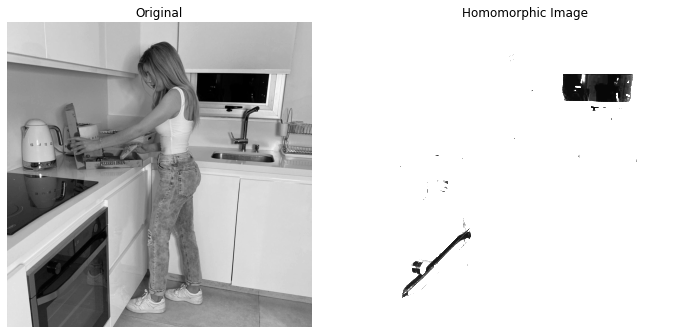

In [32]:
figure, axes = plt.subplots(ncols=2, figsize=(12, 12))
axes[0].imshow(laurita, cmap="gray", vmin=0, vmax=255)
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(homomorphic(laurita), cmap="gray", vmin=0, vmax=255)
axes[1].set_title('Homomorphic Image')
axes[1].axis('off')
plt.show()

Podemos ver en el reflejo del horno la figura de una persona que antes era imposible de observar. A continuación ampliaremos la imagen para ver mejor el reflejo.

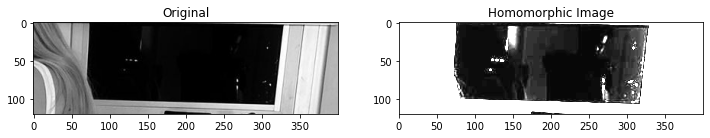

In [33]:
figure, axes = plt.subplots(ncols=2, figsize=(12, 12))
axes[0].imshow(laurita[180:300,600:1000], cmap="gray", vmin=0, vmax=255)
axes[0].set_title('Original')
axes[1].imshow(homomorphic(laurita)[180:300,600:1000], cmap="gray", vmin=0, vmax=255)
axes[1].set_title('Homomorphic Image')
plt.show()

## Conclusión del dato curioso

Podemos ver que los rumores esparcidos por el seguidor de la diva eran ciertos, se puede apreciar claramente en el reflejo del horno la figura de una persona que es muy parecida a Nicolás Cabré, recordemos, el ex de Laurita. Esto confirmaría la hipótesis que se esparció de un reencuentro entre los famosos, y lo pudimos comprobar gracias a las virtudes del filtro homomórfico.